In [1]:
from neuron import h
from neuron.units import mV, ms, mM
import numpy as np
import matplotlib.pyplot as plt
h.load_file('stdrun.hoc');
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style, rc
import numpy as np
import pickle
style.use("seaborn")
%matplotlib notebook

In [2]:
soma = h.Section(name='soma')
soma.L = soma.diam =40
soma.insert('pas')
soma.Ra = 100
soma.cm = 1

In [3]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

Define the stimulus: 8 spikes at 20 Hz + 1 spike 500 ms later

In [4]:
stimulator = h.VecStim()
spike_times = list(range(100, 450, 50)); spike_times.append(950)
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1

Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals and the Use and R

In [5]:
g_syn = h.Vector().record(synapse._ref_g)
i_syn = h.Vector().record(synapse._ref_i)
v_soma = h.Vector().record(soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)
R_syn = h.Vector().record(synapse._ref_R)
Use_syn = h.Vector().record(synapse._ref_Use)

Let's validate that the AMPA conductance is behaving as we expect

In [6]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0
h.finitialize(-70 * mV)
h.continuerun(1000 * ms);

In [7]:
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='v (mV)', constants=None):
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    plt.xlabel('t (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        

<IPython.core.display.Javascript object>


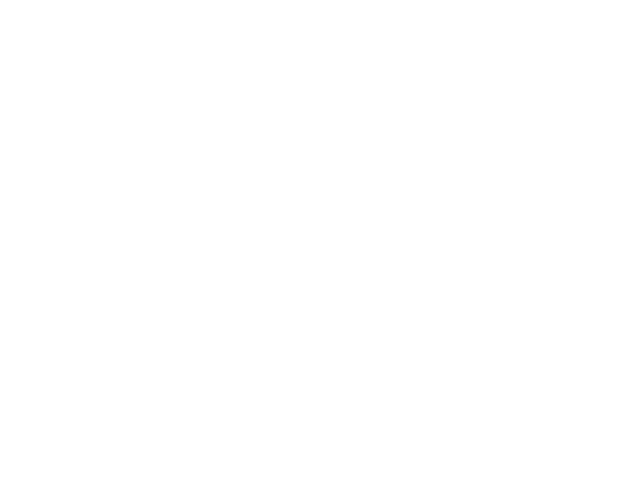

In [8]:
synapse.tau_d_NMDA = 43
synapse.gmax_AMPA =  0.001 # uS
synapse.gmax_NMDA = 0.001
h.finitialize(-70 * mV)
h.continuerun(1000 * ms);
plot_timecourse(time, g_syn*1000,ylabel='conductance (nS)')

Let's configure the synapse to realistic biological ranges for the AMPA and NMDA conductances, and the Mg2+ concentration. We'll record both the NMDA and AMPA conductances separately to visulalize their contributions to the total conductance trajectory.

In [9]:
g_NMDA = h.Vector().record(synapse._ref_g_NMDA)
g_AMPA = h.Vector().record(synapse._ref_g_AMPA)
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ration of NMDA/AMPA channels
h.finitialize(-70 * mV)
h.continuerun(1000 * ms);

NOTE! All this modelling without the Mg2+ block of NMDA channel, therefore one can observe a large conductance for NMDA channels in the model, as can be seen in the graph below by strong influence of g_NMDA on total g (conductance time course):

<IPython.core.display.Javascript object>


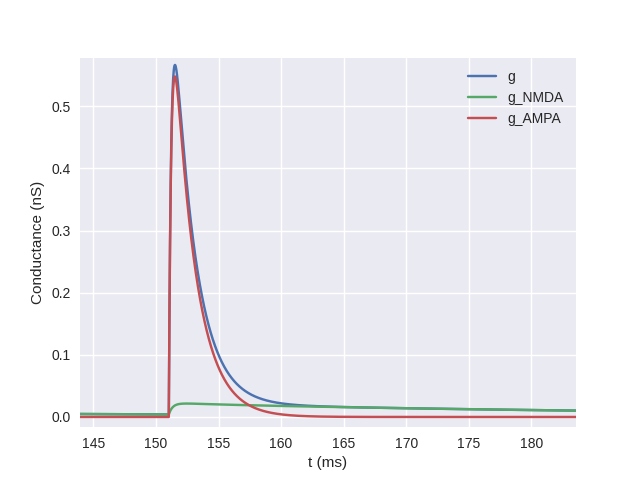

In [19]:
plot_timecourse(time, g_syn*1000, ylabel = 'Conductance (nS)', label='g', show=False)
plot_timecourse(time, g_NMDA*1000, ylabel = 'Conductance (nS)', label='g_NMDA', show=False, newfigure=False)
plot_timecourse(time, g_AMPA*1000, ylabel = 'Conductance (nS)', label='g_AMPA', newfigure=False, show=False)
plt.legend()
#plt.axis([80, 150, 0, 0.0012])
plt.show()

Finally, let's plot the dependence of the NMDA conductance on the Mg2+ concentration

In [11]:
g_NMDA_1mM = np.zeros_like(g_NMDA)
g_NMDA_1mM = g_NMDA

<IPython.core.display.Javascript object>


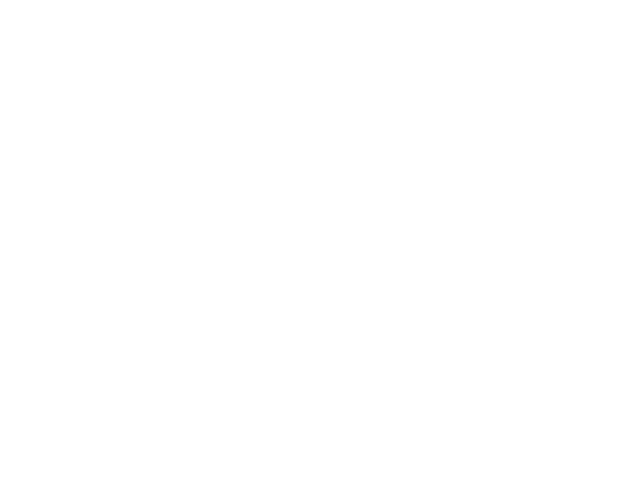

In [12]:
plot_timecourse(time, g_NMDA_1mM, ylabel='g (uS)', label='$[Mg^{2+}] = 1mM$')
mgs = [0.5, 0.25, 0.1, 0]
for mg in mgs:
    synapse.mg = mg
    h.finitialize()
    h.continuerun(1000 * ms)
    plot_timecourse(time, g_NMDA, ylabel='g (uS)', label = '$[Mg^{2+}]$ = %f mM' % mg, newfigure=False)
    plt.axis([90, 150, 0, 0.0008])
    plt.legend()

## Tsodyks and Markram model

In [13]:
synapse.gmax_AMPA = 0.002 # uS
synapse.gmax_NMDA = 0.7 * 0.002 # uS
synapse.mg = 1 # mM

Now let's configure parameters for the pseudo linear system dynamics, and simulate

In [14]:
synapse.U1 = 0.2 # Baseline release probability
synapse.tau_rec = 200
synapse.tau_facil = 200

h.finitialize();
h.continuerun(1000 * ms);

<IPython.core.display.Javascript object>


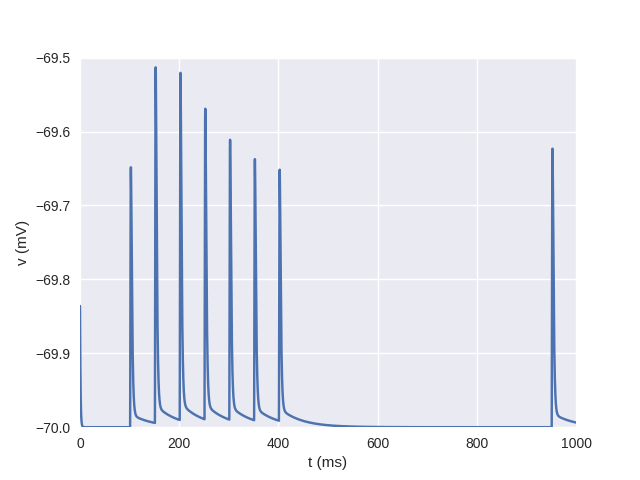

(0.0, 1000.0, -70.0, -69.5)

In [15]:
%matplotlib notebook

plot_timecourse(time, v_soma)
plt.axis((0, 1000,-70, -69.5))

Now let's plot the time course of R, Use

<IPython.core.display.Javascript object>


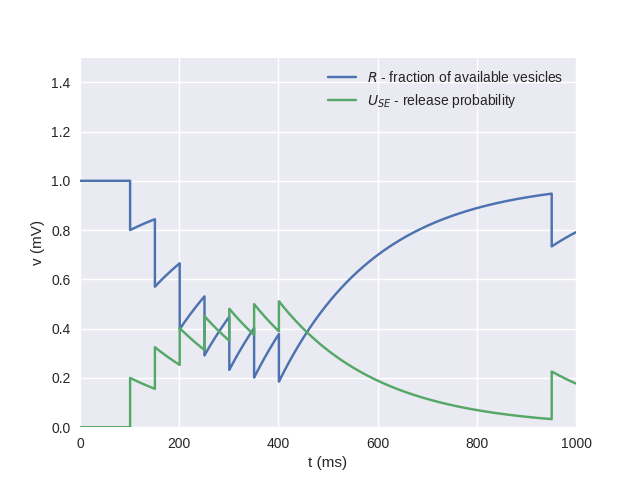

<IPython.core.display.Javascript object>


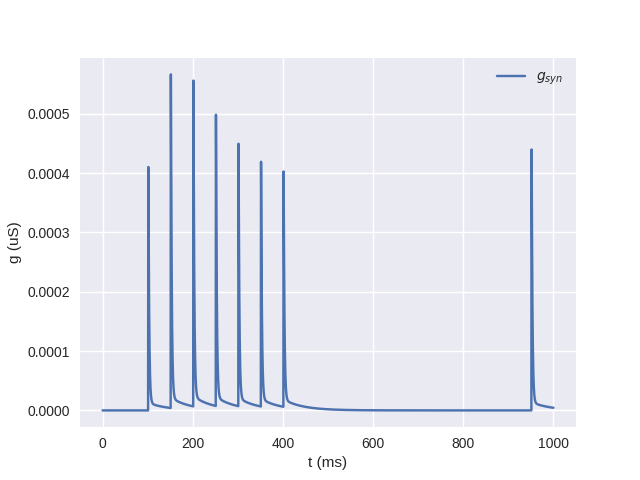

In [16]:
plot_timecourse(time, R_syn, label='$R$ - fraction of available vesicles', show=False)
plot_timecourse(time, Use_syn, label='$U_{SE}$ - release probability', newfigure=False)
plt.legend()
plt.axis((0, 1000, 0, 1.50))

plot_timecourse(time, g_syn, label='$g_{syn}$', ylabel='g (uS)')
plt.legend()